# Second Order Kuromato Chain

Investigate 

$\ddot{\theta}_i = -\alpha\dot{\theta}_i + \Omega_i + \lambda\sum_{j=1}^N A_{ij} sin(\theta_j - \theta_i)$

$A_{ij} = 1$ if and only if $|i-j|=1$, otherwise $A_{ij}=0$


## ODE Formulation

$\dot{\theta} = \omega$

$\dot{\omega} = \Omega_i - \alpha\omega + \lambda\sum_{j=1}^N A_{ij} sin(\theta_j - \theta_i)$

* $\Omega_i$ -> drive[i]
* $\alpha$ -> damping 
* $\lambda$ -> coupling

In [1]:
if isdefined(:cluster)
    using ClusterManagers
    N_tasks = parse(Int, ARGS[1])
    N_worker = N_tasks 
    addprocs(SlurmManager(N_worker))
    
else
    #addprocs(3)
    import Plots
end
Pkg.update("HighBifLib")
using JLD2, FileIO, Clustering
@everywhere using HighBifLib  
@everywhere using Distributions
@everywhere using DifferentialEquations


INFO: Updating METADATA...
INFO: Updating HighBifLib master... 3d116071 → 6cf4f68e
INFO: Computing changes...
INFO: No packages to install, update or remove


* normally the new parameter instances are constructed with reconstruct from Parameters.jl/@with_kw, here this doesn't work because we want to change $\sigma$ which is not directly a field of the struct, thus an inner constructer is used, so that par_vars has an extra element: the function that returns a new parameter instance, so the constructer itself. 

In [2]:
@everywhere N = 15
@everywhere par = second_order_kuramoto_chain_parameters(N)

@everywhere ic0 = zeros(2*N)

@everywhere ic_gen = ()->rand(Uniform(-pi,pi))
@everywhere N_ics = 1000
@everywhere sig_gen = ()->rand(Uniform(0,0.1))
@everywhere par_vars = (:sigma,sig_gen,(p;sigma=sigma)->second_order_kuramoto_chain_parameters(p;sigma=sigma))

# base problem
@everywhere kcp = ODEProblem(second_order_kuramoto_chain, ic0, (0.,800.), par)

@everywhere tail_frac = 0.9 
@everywhere mckcp = BifAnaMCProblem(kcp, ic_gen, N_ics, par, par_vars, eval_ode_run, tail_frac)
sol = solve(mckcp)

HighBifLib.myMCSol(MonteCarloSolution Solution of length 1000 with uType:
Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1},Float64}, 1000, 400, 4)

In [3]:
D = distance_matrix(sol, parameter(mckcp));
k = 4
fdist = k_dist(D,k);

INFO: Recompiling stale cache file /home/max/.julia/lib/v0.6/GR.ji for module GR.


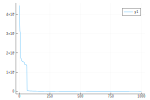

In [4]:
x = collect(1:sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [5]:
db_eps = 150
db_res = dbscan(full(D),db_eps,k)

Clustering.DbscanResult([1, 2, 6, 35, 68, 95, 811], [1, 2, 2, 0, 2, 3, 2, 1, 2, 0  …  2, 2, 2, 4, 2, 6, 2, 2, 2, 2], [20, 760, 7, 12, 6, 20, 3])

In [8]:
cluster_meas = cluster_measures(sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(parameter(mckcp),db_res,0.005,0.0001);

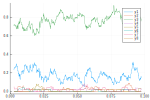

In [9]:
using Plots
plot(cluster_members[1],cluster_members[2])